In [2]:
import numpy as np
import matplotlib.pylab as plt
import sys
import pandas as pd
sys.path
sys.path.append('/Users/david/projects/vortexa/analytics')
sys.path.append('/Users/david/projects/vortexa/analytics/prediction_functions')

Generate some fake non-stationary time series data.

The time series includes trend, seasonal, and noise components.

In [3]:
ndays = 100
time = np.arange(ndays)
noise = 0.2
trend = 0.1*time
seasonal = 1* np.sin(2*np.pi* 1/30 * time)

flows = trend + seasonal + np.random.randn(ndays)*noise

Now we begin attempting to forecast beyond the final data point. First define the length of the forecast (try 30 days).

In [4]:
forecast = 30

time_total        = np.arange(ndays + forecast)
flows_total       = np.zeros(ndays + forecast)
uncertainty_total = np.zeros(ndays + forecast)

The thing to remember about forecasting is, the better the forecast gets, the less generaly it can be applied (in general). The most general forecast would be a global mean. The 1$\sigma$ (or 68 percentile) confidence limit for the global mean is just the standard deviation.

$F_i = \sum_{j=1}^{N_{lags}} W_j X_{i-j}$


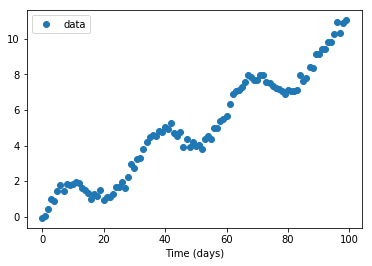

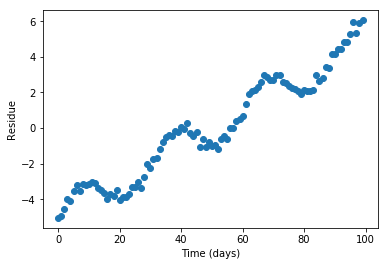

In [5]:
flows_total[:] = np.mean(flows)
uncertainty_total[:] = np.std(flows)


#plot the result
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time,flows,marker='o',ls='',label='data')
#ax1.plot(time_total,flows_total,label='mean fit',color='r')
#ax1.fill_between(time_total,flows_total - uncertainty_total, flows_total + uncertainty_total,
#                 label='uncertainty envelope',alpha = 0.2,color='r')
#ax1.set_title('Mean forecast')
ax1.set_xlabel('Time (days)')
plt.legend()
plt.savefig('mean_justdata.pdf')
plt.show()
#plot residue
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time,flows - flows_total[:ndays],marker='o',ls='',label='residue (Data - Model)')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Residue')
plt.savefig('mean_residue.pdf')
plt.show()

The next, more specific, technique would be to fit a straight line.

sigma is none
('ts variance = ', 0.5761702900558734)
('covariance matrix', array([[7.05585199e-06, 1.54510006e-13],
       [1.54510006e-13, 5.87928870e-03]]))
('number of points, number of parms, ndof', 100, 1, 98)
('covariance expansion', 0.5879288674039523)
('theoretical reduced chi squared', 1.0000000000000002)


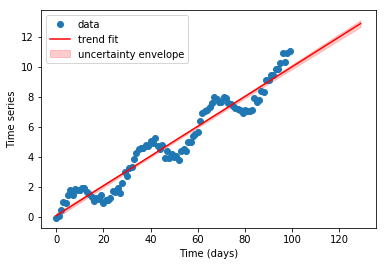

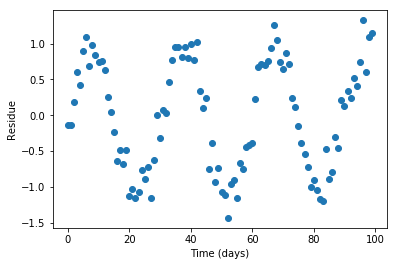

In [6]:
from prediction_functions.polyfit import *
output = fit(time, flows, order=1, xgrid=time_total, confidence=0.3173, nits=20000, figure_title='', verbose=False)
yg_med, yg_lo, yg_hi, cov, cisq, cisq_red, bic, aic, rmd, r2 = output


#plot the result
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time,flows,marker='o',ls='',label='data')
ax1.plot(time_total,yg_med,label='trend fit',color='r')
ax1.fill_between(time_total,yg_lo,yg_hi,label='uncertainty envelope',color='r',alpha=0.2)
plt.legend()
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Time series')
plt.savefig('trend.pdf')
plt.show()

#plot residue
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time,flows - yg_med[:ndays],marker='o',ls='',label='residue (Data - Model)')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Residue')
plt.savefig('trend_residue.pdf')
plt.show()

These methods, while general, do not allow fitting seasonal components. For that, we need a fourier based approach. Fouriers theorem tells us that any signal can be decomposed into a sum of sine and cosine waves.

$f(t) = \sum_{k=0}^{k=k_\mathrm{max}} S_k \sin \left( 2 \pi f_k t \right) + C_k \cos \left( 2 \pi f_k t \right)$

where, for a time series of length $T$, the 'fittable' frequencies take the form

$f_k = k \frac{1}{2} T$ where $k_\mathrm{min} = 0$ and $k_\mathrm{max} = \frac{T}{\Delta t}$.

The upper frequency limit is known as the 'Nyquist Frequency' and cannot be exceeded using standard methods as all frequencies abnove this are degenerate parameters. 

Lets combine the fourier method with the polynomial trend fits (just to say I did this before the facebook prophet algorithm came out... just saying).

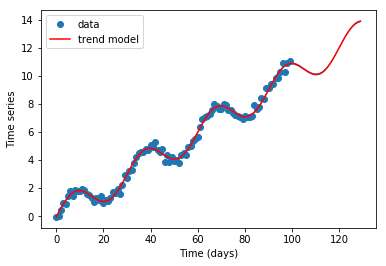

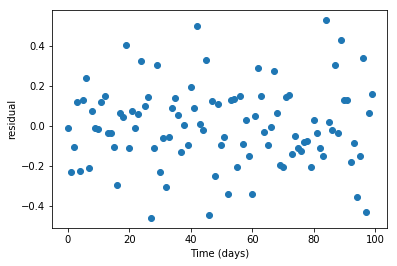

In [7]:
from prediction_functions.rw_poly_combined import *

output = rw(time,flows,si = np.ones(ndays)*noise, tgi = time_total,custom_freqs=np.array([1./30]))
tgrid,ygrid,frequencies,Ck,Sk,poly_coef,rc = output
yg_lo,yg_med,yg_hi = ygrid[:,0],ygrid[:,1],ygrid[:,2]


#plot the result
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time,flows,marker='o',ls='',label='data')
ax1.plot(time_total,yg_med,color='r',label='trend model')
ax1.set_xlabel('Time (days)')
ax1.fill_between(time_total,yg_lo,yg_hi)
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Time series')
plt.savefig('trend_season.pdf')
plt.legend()
plt.show()

#plot residue
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time,flows - yg_med[:ndays],marker='o',ls='',label='residue (Data - Model)')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('residual')
plt.savefig('trend_season_residue.pdf')
plt.show()

In [8]:
import pandas as pd
#generate fake data
n = 3 * 365
dt = 1
time = np.arange(0, n, dt)
predict = 100
time_extra = np.arange(0, time[-1] + (predict + 1) * dt, dt)
noise = 0.3
y_flows_true = np.sin(2 * np.pi * 1. / 365 * time_extra) + 0.3 * np.sin(2 * np.pi * 1. / 90 * time_extra)
y = y_flows_true + noise * np.random.randn(n + predict)
y_train = y[:-predict]
# select an arb that leads by 100 days
y_arb = np.roll(y_flows_true, -100) + noise * np.random.randn(n + predict)
y_components = np.zeros((n + predict, 1))
y_components[:, 0] = y_arb
y_components_train = y_components[:-predict]
# specify the dates of the observations (list of dataframes)
today = pd.datetime.now()
dates = pd.date_range(start=today, periods=n)

Demonstrate cross correaltion

$CCF(\tau ) = \frac{\sum_{i=1}^{N} (X_i(t) - <X>) (F_i(t-\tau) - <F>) }{\sqrt{ Var(X) Var(Y) }}$

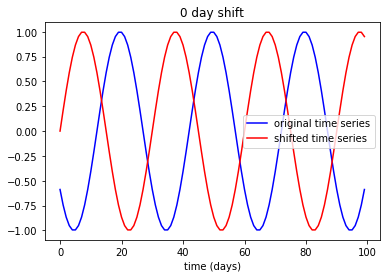

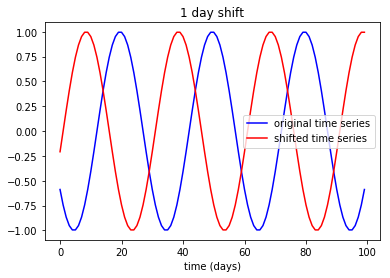

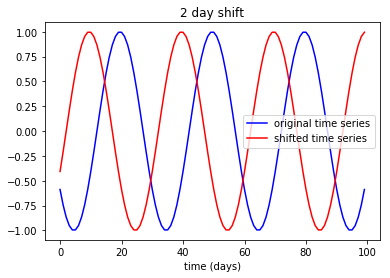

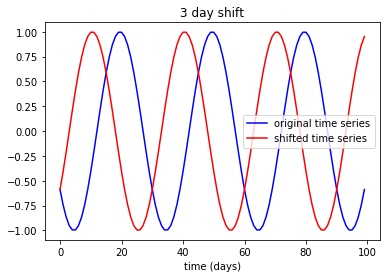

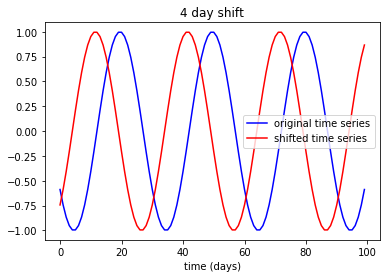

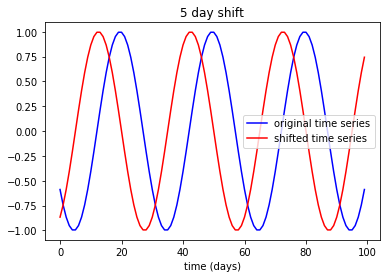

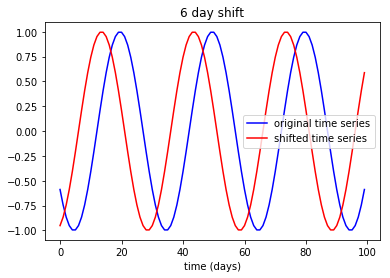

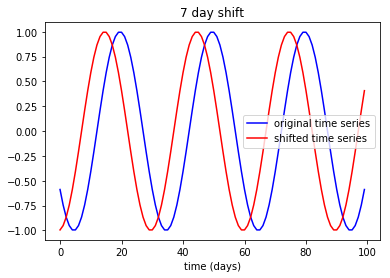

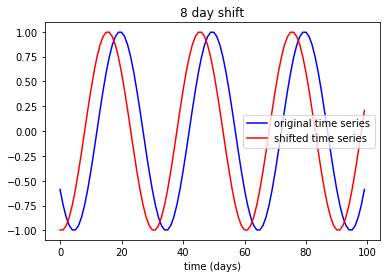

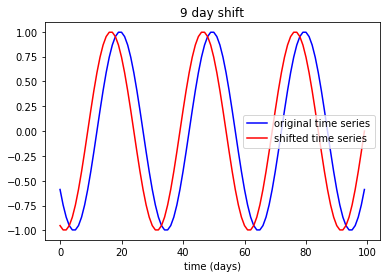

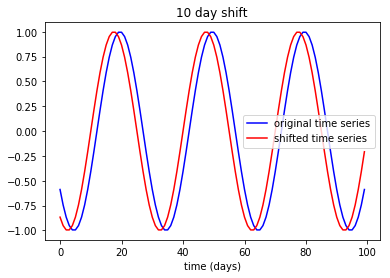

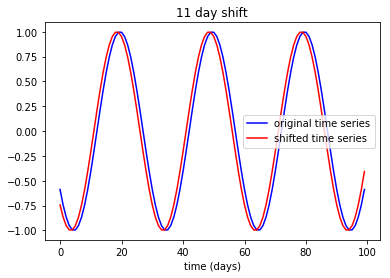

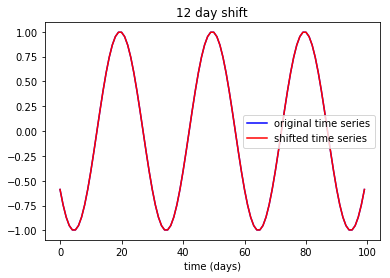

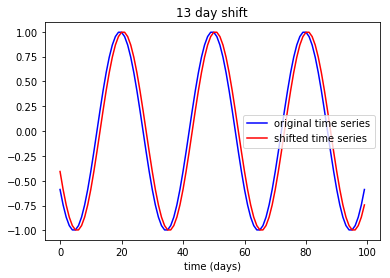

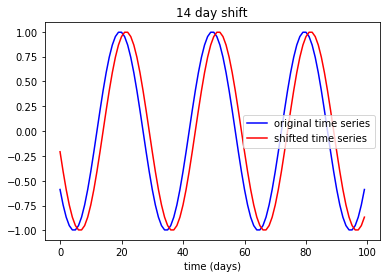

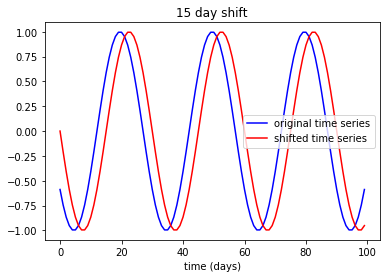

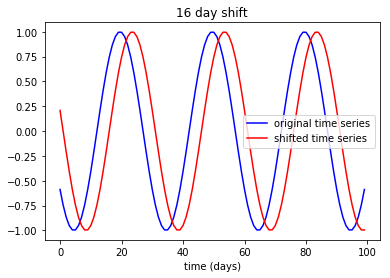

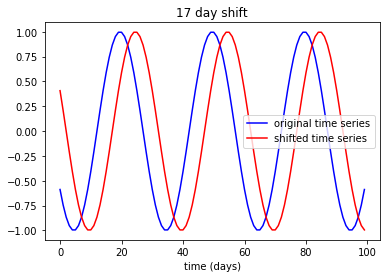

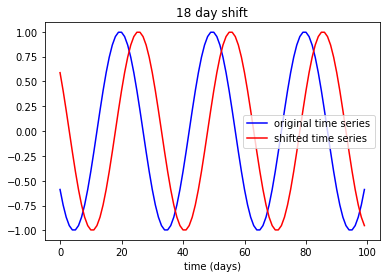

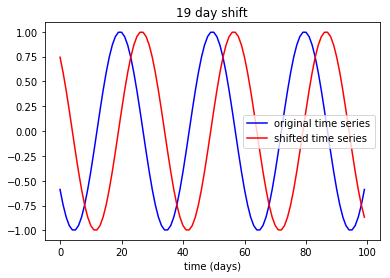

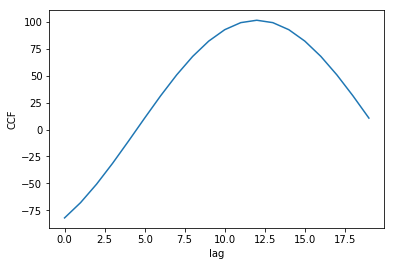

In [22]:
t = np.arange(100)
lag = 12
y = np.sin(2*np.pi/30 * (t-lag))

ysd = np.std(y)
lagtest = np.arange(0,20)
ccf = []
idx = 1
for lagnow in lagtest:
    ynew = np.sin(2*np.pi/30 * (t - lagnow))
    ccf.append(np.sum(y*ynew)/ysd/ysd)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(t,y,label='original time series',color='b')
    ax1.plot(t,ynew,label = 'shifted time series',color='r')
    ax1.set_title(np.str(lagnow)+' day shift')
    ax1.set_xlabel('time (days)')
    ax1.set_ylabel('')
    plt.legend()
    plt.savefig('./figures/timeseries_ccf_'+str("%05d" % idx)+'.jpg')
    idx = idx + 1
    
import os
os.system('ffmpeg -framerate 1 -i ./figures/timeseries_ccf_%05d.jpg -c:v libx264 -vf fps=25 -pix_fmt yuv420p ./figures/timeseries_ccf_demo.mp4')


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(lagtest,ccf)
ax1.set_xlabel('lag')
ax1.set_ylabel('CCF')
plt.savefig('ccf_figure.pdf')
plt.show()

    

Demonstrate overfitting problem and resolution with AIC

('figure ', 1, ' of ', 218)
('figure ', 2, ' of ', 218)
('figure ', 3, ' of ', 218)
('figure ', 4, ' of ', 218)
('figure ', 5, ' of ', 218)
('figure ', 6, ' of ', 218)
('figure ', 7, ' of ', 218)
('figure ', 8, ' of ', 218)
('figure ', 9, ' of ', 218)
('figure ', 10, ' of ', 218)
('figure ', 11, ' of ', 218)
('figure ', 12, ' of ', 218)
('figure ', 13, ' of ', 218)
('figure ', 14, ' of ', 218)
('figure ', 15, ' of ', 218)
('figure ', 16, ' of ', 218)
('figure ', 17, ' of ', 218)
('figure ', 18, ' of ', 218)
('figure ', 19, ' of ', 218)
('figure ', 20, ' of ', 218)
('figure ', 21, ' of ', 218)
('figure ', 22, ' of ', 218)
('figure ', 23, ' of ', 218)
('figure ', 24, ' of ', 218)
('figure ', 25, ' of ', 218)
('figure ', 26, ' of ', 218)
('figure ', 27, ' of ', 218)
('figure ', 28, ' of ', 218)
('figure ', 29, ' of ', 218)
('figure ', 30, ' of ', 218)
('figure ', 31, ' of ', 218)
('figure ', 32, ' of ', 218)
('figure ', 33, ' of ', 218)
('figure ', 34, ' of ', 218)
('figure ', 35, ' of ',

256

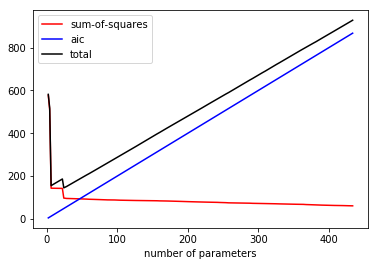

In [16]:
from prediction_functions.rw_poly_combined import *
idx = 0
cost_function = []
aic_cost      = []
combined_cost = []
n_parameters  = []
freqs = np.arange(1./n,0.2/dt,1./n)
plots = True
for i in range(1,len(freqs),1):
    number_of_parms = idx + 2
    
    #fit the model
    tgrid,model,f,ckou,skout,poly_coef,rcoef = \
    rw(time,y_train,si=None,tgi = time_extra,fbreak=-1,custom_freqs=freqs[:i],nits = 1,order = 1)
    model_extra = model[:,1]
    tgrid_extra = 1.*tgrid
    tgrid = tgrid[:n]
    model = model[:n,1]
    
    
    #evaluate the cost function and aic
    sum_of_squares = np.sum((y_train - model)**2)
    cost_function.append(sum_of_squares)
    aic = 2*number_of_parms
    aic_cost.append( aic )
    #bic = cost_function + number_of_parms*np.log(n)
    combined_cost.append(sum_of_squares + aic)
    n_parameters.append(number_of_parms)
    idx = idx + 2
    #print(1./freqs[i],sum_of_squares)
    if plots is True:
     print('figure ',i,' of ',len(freqs))
     fig = plt.figure()
     ax1 = fig.add_subplot(111)
     ax1.plot(time,y_train,label='data',color='b')
     ax1.plot(tgrid_extra,model_extra,label='model',color='r')
     ax1.set_xlabel('time  (days)')
     ax1.set_ylabel('flows (normalised units)')
     ax1.set_ylim([-2,2])
     ax1.set_title('number of parameters: '+np.str(number_of_parms))
     plt.legend()
     plt.savefig('./figures/overfitting_'+str("%05d" % i)+'.pdf')
     plt.close()
  

#produce figure of fit vs number_of_parms
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(n_parameters,cost_function,label='sum-of-squares',color='r')
ax1.plot(n_parameters,aic_cost,label='aic',color='b')
ax1.plot(n_parameters,np.array(aic_cost)+np.array(cost_function),
         label='total',color='k')
ax1.set_xlabel('number of parameters')
plt.legend()
#ax1.plot(n_parameters,combined_cost,label='combined cost')
plt.savefig('./figures/aic_cost.pdf')
    
    

#convert movies into figures
#use ffmpeg 'brew install ffmpeg'
import os
os.system('ffmpeg -r 1/5 -i ./figures/overfitting_%05d.pdf -c:v libx264 -vf fps=25 -pix_fmt yuv420p ./figures/high_quality_overfit.mp4')




Install and run fish forecasting code on synthetic time series data

In [9]:
# this is how to install and use the forecast class
# cd analytics/fish_forecast
# pip install .
import fish_forecast
a = fish_forecast.forecast()
a.set_dates(dates)
a.set_main_timeseries(y_train)
a.set_contributing_timeseries(y_components_train)
a.predict(days=90)
a.plot()
plt.show()

ImportError: No module named fish_forecast

Now apply to real flow timeseries data (Gasoline flows from NWE --> Canada East Coast).

In [ ]:
path='/Users/david/github_datascience/vortexa/analytics/arbitrage_flow_study/resources/vortexa_gasoline_naphtha_1day/'
file = 'gasoline_nwe_usaccec.csv'
flows = pd.read_csv(path + file)

#import and run the code
import fish_forecast
forecast = fish_forecast.forecast()
forecast.add_raw_timeseries(flows['quantity (bbl)'],flows['Quantity loaded on'])
forecast.predict_ar_model(days=90
                          #,periods = 365*np.array([0.25,0.5,1.0,2.0])
                         )
forecast.plot()
plt.show()

#export the predictions
forecast.export_csv(path = path, file = 'fish_predictions_'+file)
